# Анализ и сегментация клиентов банка "Метанпром" по потреблению

Для того, чтобы скорректировать стратегию взаимодействия с клиентами, необходимо провести анализ клиентов в зависимостии от количества потребляемых продуктов. Требуется также проверить гипотезу о различиях в доходе между клиентами с 1 и 2 продуктами.

##### Исследование разделим на несколько частей.

##### Шаг 1. Изучение общей информации и первичная подготовка данных:
* [1. Изучение файлов с данными, получение общей информации.](#step1)
* [2. Работа с дубликатами и пропушенными значениями.](#step1_2)

##### Шаг 2. Исследовательский анализ данных:
* [1. Анализ описательных статистик показателей.](#step2_1)
* [2. Изучение распределения признаков.](#step2_2)
* [3. Выявление аномалий.](#step2_3)
* [4. Корреляционный анализ](#step2_4)

##### Шаг 3.  Сегментация клиентов по потреблению:
* [1. Выделение сегментов. Общий анализ сегментов. Выделение портретов пользователей по сегментам.](#step3_1)
* [2. Анализ сегментов по доходам.](#step3_2)
* [3. Анализ сегментов по оттоку.](#step3_3)

##### Шаг 4.  Проверка статистических гипотез
* [1. Проверка гипотезы о равенстве доходов между сегментами.](#step4_1)
* [2. Проверка гипотезы о равенстве оттока клиентов между сегментами.](#step4_2)

##### Шаг 5. Общий вывод
* [1. Формирование общих выводов.](#step5_1)
* [2. Формирование рекомендаций по результатам исследования.](#step5_2)
* [3. Дополнительные материалы к исследованию.](#step5_3)

### Шаг 1. Изучение общей информации и первичная подготовка данных

#### 1.1 Изучение файлов с данными, получение общей информации.
<a id='step1_1'></a>

Загрузим неоюбходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('bank_dataset.csv')

Ознакомимся с данными 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


*Всего у нас 10000 строк и 12 столбцов. С типами данных все в порядке. Столбец Balance содержит пропуски. Обработаем их в следующем подразделе.*

Создадим словарь с переводом наименований признаков

In [5]:
feature_translate = {'userid':'Идентификатор пользователя', 
                     'score':'Баллы кредитного скоринга', 
                     'City':'Город', 
                     'Gender':'Пол', 
                     'Age':'Возраст', 
                     'Objects':'Количество объектов в собственности', 
                     'Balance':'Баланс на счёте',
                     'Products':'Количество используемых продуктов', 
                     'CreditCard': 'Наличие кредитной карты', 
                     'Loyalty': 'Активный клиент', 
                     'estimated_salary': 'Размер заработной платы', 
                     'Churn':'Отток',
                     'City_Ростов Великий': 'Ростов Великий',
                     'City_Рыбинск': 'Рыбинск',
                     'City_Ярославль': 'Ярославль'
                    }

Создадим словарь единиц измерений числовых признаков

In [6]:
feature_unit = {'score':'Балл',
                'Age':'Годы',
                'Balance':'Руб.',
                'Products':'Количество продуктов',
                'Lifetime':'Количество месяцев',
                'estimated_salary':'Руб.'}


#### 1.2 Работа с дубликатами и пропушенными значениями.
<a id='step1_2'></a>

Проверим строки на полные дубликаты

In [7]:
df.duplicated().sum()

0

Проверим нет ли задвоенных данных по пользователям

In [8]:
df.duplicated(subset=['userid']).sum()

0

Посчитаем промежуточные итоги по столбцам estimated_salary и Balance для дальнейшей перепроверки.

In [9]:
total_salary = df['estimated_salary'].sum()
total_salary

1000902398.8100001

In [10]:
total_balance = df['Balance'].sum()
total_balance

764858892.8800001

Теперь вернемся к пропущенным значениям в столбце Balance. Найдем их количество

In [11]:
df['Balance'].isna().sum()

3617

36% - это существенная часть данных. Построем распределение переменной и рассчитаем описательные статистики.

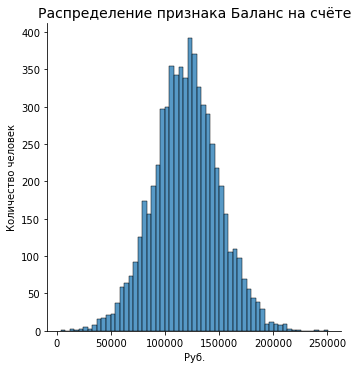

In [12]:
sns.displot(df, x='Balance')
plt.title(f"Распределение признака {feature_translate['Balance']}", fontsize=14)
plt.ylabel('Количество человек')
plt.xlabel(feature_unit['Balance'])
plt.show();

In [13]:
df['Balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: Balance, dtype: float64

*Распределение близкое к нормальному. Видимо у некоторых клиентов либо нет дебетового счета, возможно они пользуются только кредитным продуктом, либо общий отрицательный баланс. Поэтому и существуют пропуски в этом столбце. В таком случае целесообразно заполнить их нолями.*

In [14]:
df['Balance'] = df['Balance'].fillna(0)

In [15]:
df['Balance'].isna().sum()

0

**Вывод по шагу 1:**


* В таблице df содержаться данные об 10 000 клиентов банка "Метанпром": пол, возраст, город проживания, баланс, зарплата, количество объектов в собственности, количество используемых продуктов, наличие кредитной карты, указание на лояльность клиента, а также информация о том ушел клиент или остался.   

* Типы данных - корректны, дубликаты отсутствуют. В столбце баланса клиента отсутствовало 36% значений. Это клиенты без положительного дебетового баланса. Пропуски заполнены нулями.

* Для того, чтобы скорректировать стратегию взаимодействия с клиентами, необходимо провести анализ клиентов в зависимостии от количества потребляемых продуктов

### Шаг 2. Исследовательский анализ данных

#### 2.1. Анализ описательных статистик признаков.
<a id='step2_1'></a>

Рассчитаем основные описательные статистики для наших данных.

In [16]:
df.drop('userid', axis=1).describe()

,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


* В целом из 10000 клиентов в отток попало 20,4%. 
* Клиенты банка - это люди от 18 до 90 лет. Средний возраст клиента 39 лет. 
* Минимальный балл кредитного скорринга 350, максимальный 850. В среднем 650.
* 70% клиентов имеют кредитную карту.
* 51% - это лояльные клиенты.
* Клиенты используют от 1 до 4 продуктов банка. Средний показатель - 1,5
* Средняя зарплата состовляет около 100000 руб. Минимальная 11,58. Слишком маленький показатель. Необходимо исследовать этот показатель в дальнейшем.

Далее изучим распределение признаков

#### 2.2 Изучение распределения признаков.
<a id='step2_2'></a>

Создадим список с числовыми переменными

In [17]:
num_col=['score', 'Age', 'Balance', 'estimated_salary']

Создадим список с категориальными переменными

In [18]:
cat_col=['City', 'Gender', 'Objects', 'Products', 'CreditCard', 'Loyalty', 'Churn']

Для числовых признаков построем гистограмму распределения

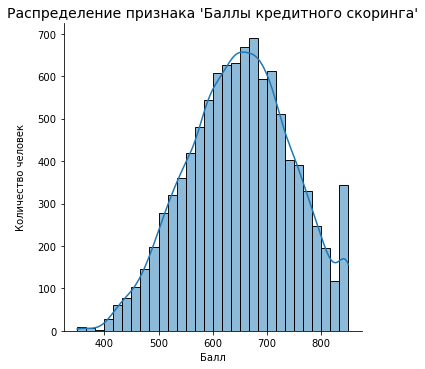

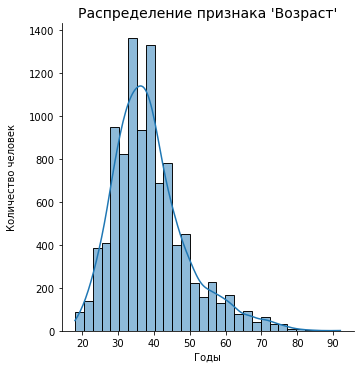

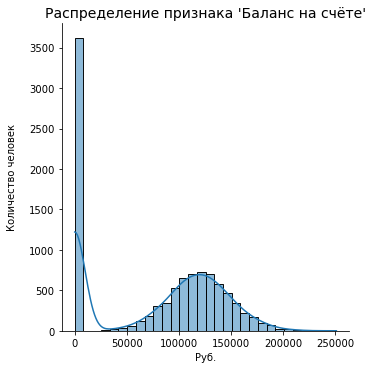

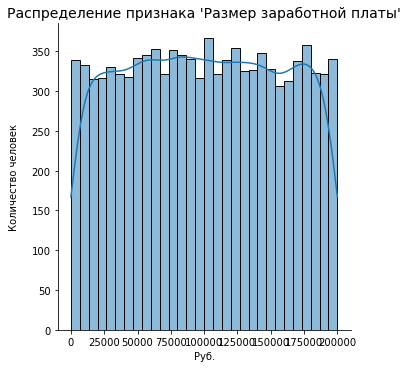

In [19]:
for col in num_col:
    sns.displot(df, x=col, kde=True, bins=30)
    plt.title(f"Распределение признака '{feature_translate[col]}'", fontsize=14)
    plt.ylabel('Количество человек', labelpad=12)
    plt.xlabel(feature_unit[col])
    plt.show();

**Из графиков распределения числовых переменных можно проследить следующие закономерности:**
* Распределение признака "Баллы кредитного скорринга" близко к нормальному, за исключением максимальной отметки 850 баллов, которой соответсвуют 350 человек.
* Распределение признака "Возраст" имеет длинный правый хвост, возможно здесь присутствуют аномально высокие значения.
* Распределение признака "заработная плата" отлично от нормального, распределение достаточно равномерное. Эти данные также следует проверить на аномальные значения.

Для категориальных переменных построем barplot

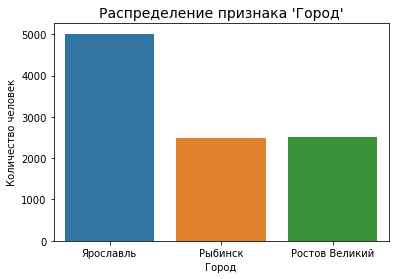

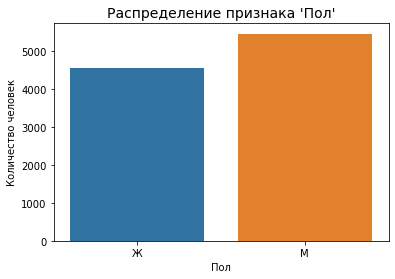

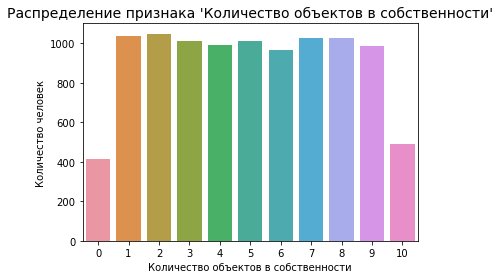

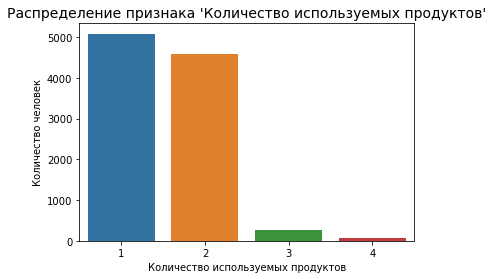

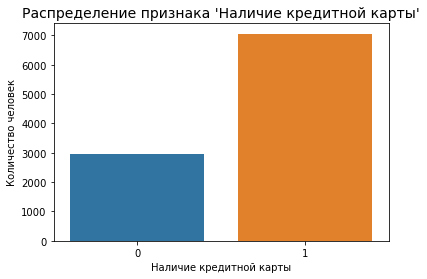

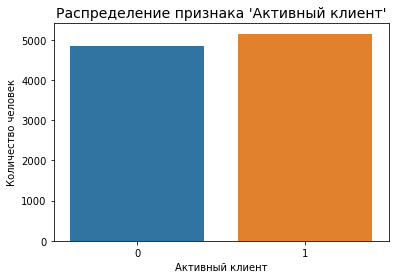

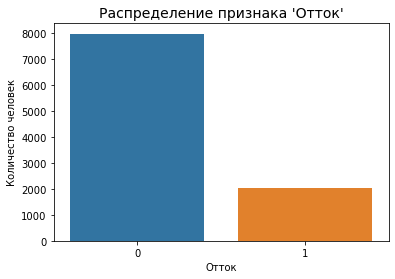

In [20]:
for col in cat_col:
    sns.countplot(x=col, data=df)
    plt.title(f"Распределение признака '{feature_translate[col]}'", fontsize=14)
    plt.ylabel('Количество человек')
    plt.xlabel(feature_translate[col])
    plt.show();

**Из графиков категориальных переменных можно проследить следующие закономерности:**
* Почти половина клиентов проживает в городе Ярославль. Остальные поровну поделены между Рыбинском и Ростовом.
* Мужчин больше, чем женщин почти на 1000 человек.
* Распределение по признаку "Количество объектов в собственности" от 1 до 9 - равномерное.
* Половина клиентов - пользуется только 1 продуктом, 4500 клиентов - двумя, и только 500 человек - используют 3 и более продукта.
* Почти 7000 клиентов имеют кредитную карту.
* В отток ушло около 2000 клиентов.

#### 2.3. Выявление аномалий.
<a id='step2_3'></a>

Для выявления аномалий нарисуем boxplot по числовым переменным

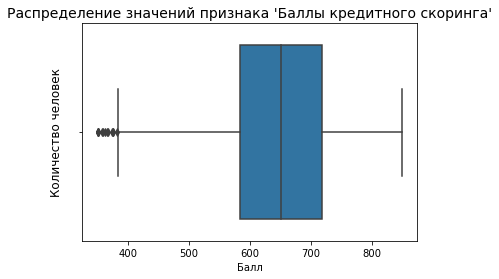

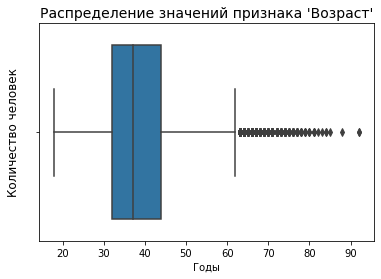

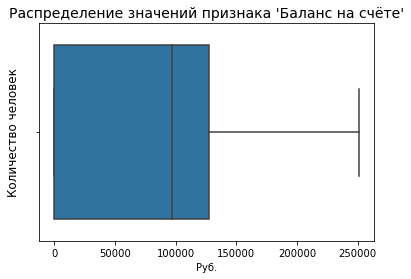

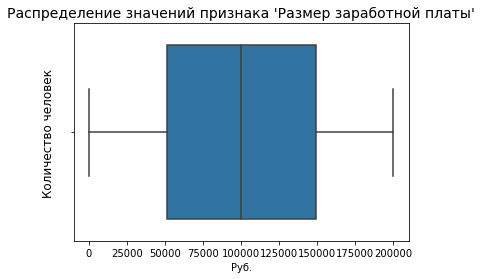

In [21]:
for col in num_col:
    sns.boxplot(x=df[col])
    plt.title(f"Распределение значений признака '{feature_translate[col]}'", fontsize=14)
    plt.ylabel('Количество человек', fontsize=12, labelpad=12)
    plt.xlabel(feature_unit[col])
    plt.show();

Посмотрим перцентели по столбцам Age и score

In [22]:
np.percentile(df['Age'], [95, 97.5, 99])

array([60., 66., 72.])

Всего 1% пользователей старше 72 лет, 5% - старше 60.

In [23]:
np.percentile(df['score'], [5, 2.5, 1])

array([489., 461., 432.])

Всего 1% пользователей имеет балл кредитного скорринга ниже 432, 5% - ниже 489.

Теперь посмотрим, сколько пользователей, у которых баланс на счете сильно превышает оценку заработной платы. Для этого рассчитаем коэффициент (Баланс / Заработная плата)

In [24]:
df['bal_coef'] = df['Balance'] / df['estimated_salary']

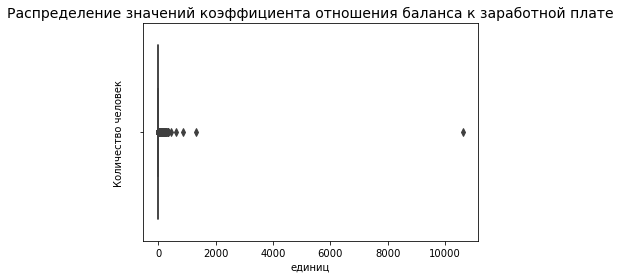

In [25]:
sns.boxplot(x=df['bal_coef'])
plt.title(f"Распределение значений коэффициента отношения баланса к заработной плате", fontsize=14)
plt.ylabel('Количество человек', labelpad=12)
plt.xlabel("единиц")
plt.show();

In [26]:
np.percentile(df['bal_coef'], [95, 97.5, 99])

array([ 7.24950025, 14.08391503, 35.48470939])

*Т.к. целью нашего исследования является выделение наиболее привлекательных групп и корректировка стратегии взаимодействия с ними, нам следует убрать из исследования данные очень пожилых клиентов (более 72 лет), клиентов с низким показателем кредитного скорринга (менее 432), клиентов с неверной оценкой заработной платы (превышение баланса над зарплатой в 35 раз).*

In [27]:
old_users = pd.concat([df[df['Age'] > 72]['userid']], axis = 0)

In [28]:
low_score_users = pd.concat([df[df['score'] < 432]['userid']], axis = 0)

In [29]:
high_coef_users = pd.concat([df[df['bal_coef'] > 35]['userid']], axis = 0)

Выделим аномальных пользователей в переменную abnormalUsers.

In [30]:
abnormalUsers = pd.concat([old_users, low_score_users, high_coef_users], axis = 0).drop_duplicates().sort_values()

In [31]:
abnormalUsers.count()

284

Всего таких пользователей 284 человека. Приготовим таблицу без данных пользователей

In [32]:
data = pd.concat([df[np.logical_not(df['userid'].isin(abnormalUsers))]], axis = 0)

In [33]:
data['userid'].count()

9716

В новой таблице содержаться данные о 9716 человек

#### 2.4. Корреляционный анализ.
<a id='step2_4'></a>

Преобразуем категориальные переменные.

In [34]:
cor_data = pd.get_dummies(data)

In [35]:
cor_data.head()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn,bal_coef,City_Ростов Великий,City_Рыбинск,City_Ярославль,Gender_Ж,Gender_М
0,15677338,619,42,2,0.00,1,1,1,101348.88,1,0.000000,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0.744677,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,1.401375,0,0,1,1,0
3,15744090,699,39,1,0.00,2,0,0,93826.63,0,0.000000,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,1.587055,0,1,0,1,0


Удалим столбец Gender_Ж и переименуем столбец Gender_М. В новом столбце gender: Мужчина - это 1, Женщина - это 0.

In [36]:
cor_data=cor_data.drop(['Gender_Ж'], axis=1)

In [37]:
cor_data=cor_data.rename(columns={"Gender_М": "Gender"})

М - это 1, Ж - это 0

Построем карту корреляций между признаками.

In [38]:
corr_m = cor_data.drop(['userid', 'bal_coef'], axis=1).corr()

In [39]:
labels = []

In [40]:
for col in cor_data.drop(['userid', 'bal_coef'], axis=1).columns:
    labels.append(feature_translate[col])

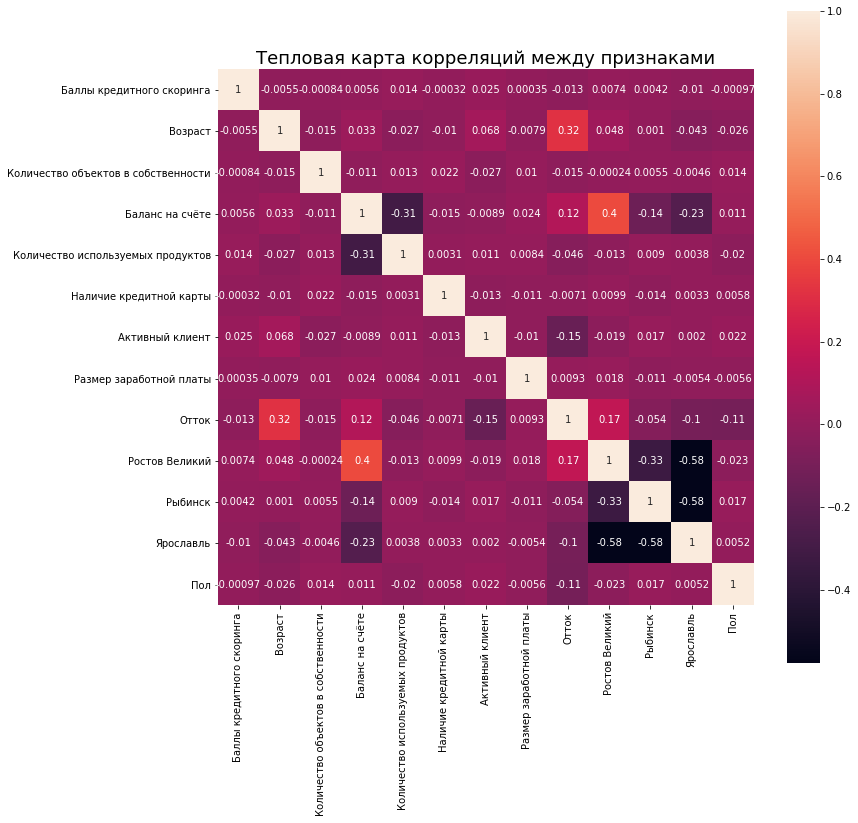

In [41]:
plt.figure(figsize=(12,12))
sns.heatmap(corr_m, square = True, annot = True, yticklabels=labels, xticklabels=labels)
plt.title('Тепловая карта корреляций между признаками', fontsize=18)
plt.show();

Исходя из попарных корреляций можно сделать следующие выводы:
* Не наблюдается высоких корреляций между признаками
* Наибольшая взаимосвязь наблюдается между признаками "баланс" и нахождением клиента в г. Ростов (0,4);
* Между показателями оттока и количеством используемых продуктов отрицательная слабая взаимосвязь (-0,3);
* Коэффициент корреляции между возрастом и оттоком составляет 0,32.

**Вывод по шагу 2**

**В ходе исследовательского анализа данных выяснили следующее:**
* В целом из 10000 клиентов в отток попало 20,4%. Средний возраст клиента 39 лет. Мужчин больше, чем женщин почти на 1000 человек.
* 70% клиентов имеют кредитную карту. 51% - это лояльные клиенты. Средняя зарплата состовляет около 100000 руб.
* Почти половина клиентов проживает в городе Ярославль. Остальные примерно поровну поделены между Рыбинском и Ростовом.
* Половина клиентов - пользуется только 1 продуктом, 4500 клиентов - двумя, и только 500 человек - используют 3 и более продукта.
* Распределение признаков "заработная плата", "количество объектов в сотбственности" отличны от нормального, распределение достаточно равномерное. 
* Не наблюдается сильных корреляций между признаками. Определенная положительная взаимосвязь прослеживается между признаками "Баланс" и местонахождением клиента, между возрастом и оттоком, а также отрицательная - между оттоком и количеством продуктов

**Т.к. целью нашего исследования является выделение наиболее привлекательных групп и корректировка стратегии взаимодействия с ними, мы убрали из исследования данные 284 человек: старше 72 лет, клиентов с показателем кредитного скорринга менее 432,  клиентов с неверной оценкой заработной платы (превышение баланса над зарплатой в 35 раз)**

### Шаг 3.  Сегментация клиентов по потреблению

#### 3.1. Выделение сегментов. Общий анализ сегментов. Выделение портретов пользователей по сегментам.
<a id='step3_1'></a>

Еще раз взглянем на распределение клиентов по количеству продуктов 

In [42]:
data['Products'].value_counts()

1    4916
2    4480
3     261
4      59
Name: Products, dtype: int64

Объединим клиентов с 3 и 4 продуктами в группу с 2 продуктами. Итого у нас получится 2 примерно равные группы: клиенты с 1 продуктом и клиенты с 2 и более продуктами.

In [43]:
data.loc[data['Products']==3, 'Products']= 2

In [44]:
data.loc[data['Products']==4, 'Products']= 2

Посмотрим на средние значения признаков по двум группам.

In [45]:
prod_groups=data.drop(['userid'], axis=1).groupby(by='Products').mean()
prod_groups

,score,Age,Objects,Balance,CreditCard,Loyalty,estimated_salary,Churn,bal_coef
Products,,,,,,,,,
1,651.296176,39.301058,4.969691,98420.322980,0.703417,0.500814,100878.311198,0.276851,2.026031
2,654.212292,37.838542,5.051042,53215.801519,0.707292,0.524167,101517.618529,0.127500,1.002071


*Из расчета средних показателей бросается в глаза различия в столбце "баланс" - почти в 2 раза больше по группе с 1 продуктом. При этом отток в группе с 1 продуктом составляет 27,7%, а в группе с 2 и более - 12,8%.*  

Построем графики распределения признаков с разбивкой по группам.

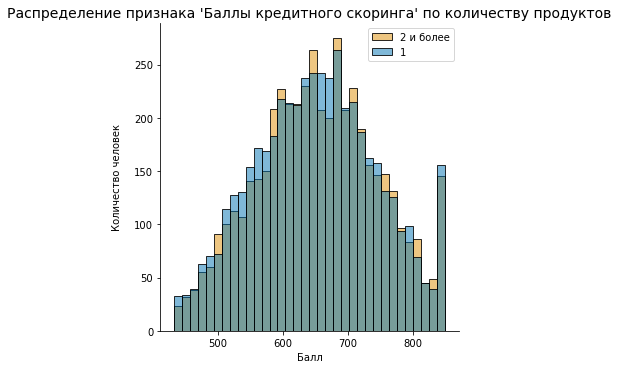

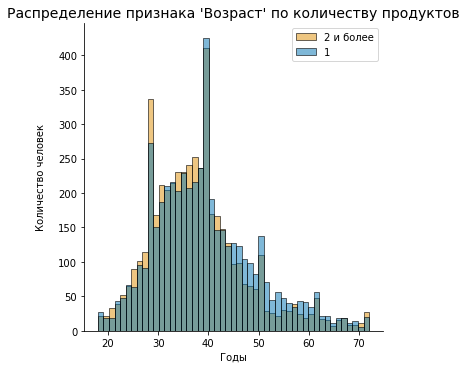

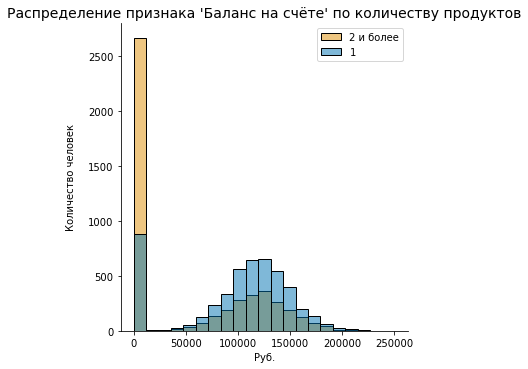

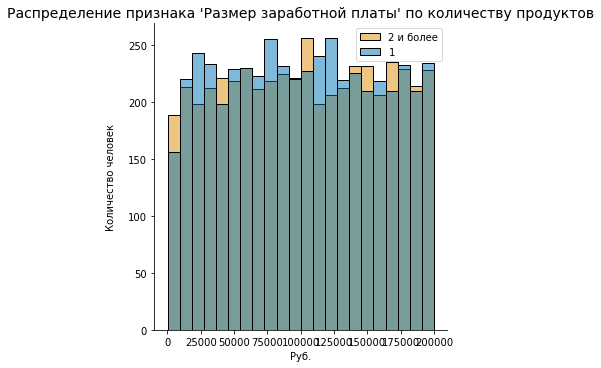

In [46]:
for col in num_col:
    sns.displot(data, x=col, hue='Products', palette='colorblind', legend=False)
    plt.title(f"Распределение признака '{feature_translate[col]}' по количеству продуктов", fontsize=14)
    plt.ylabel('Количество человек', labelpad=12)
    plt.xlabel(feature_unit[col])
    plt.legend(('2 и более', '1'))
    plt.show();

В группу с 1 продуктом попало меньшее количество пользователей, по которым баланс отрицательный. Поэтому средний баланс в этой группе выше. Следовательно, в группе с 2 продуктами больше пользователей кредитных продуктов, отсюда и более низкий средний баланс. Показатели возраста, кредитного скорринга, заработной платы распределены по группам более равномерно.

Расмотрим распределение категориальных признаков

In [47]:
cat_col=['Gender', 'Objects', 'CreditCard', 'Loyalty', 'Churn', 'City']

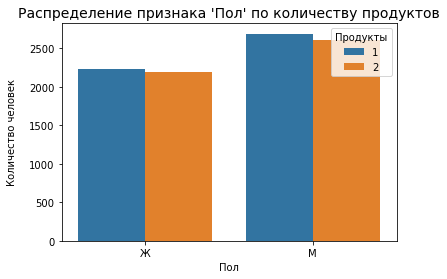

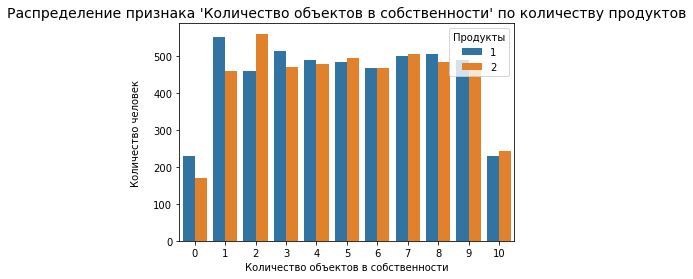

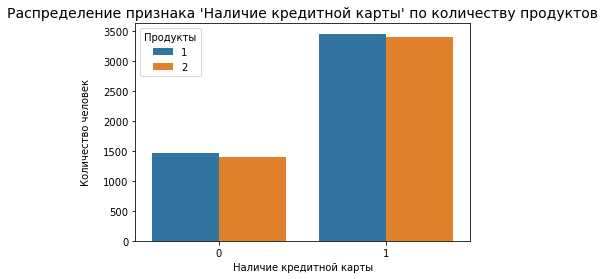

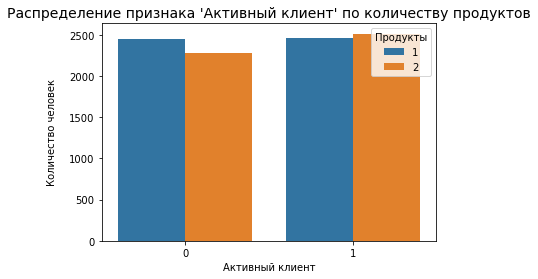

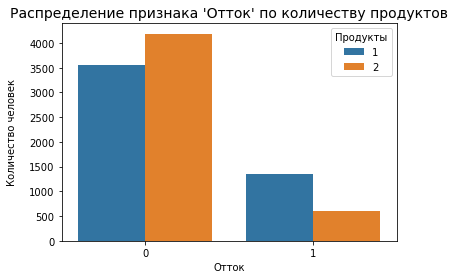

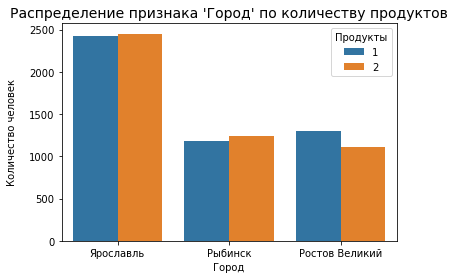

In [48]:
for col in cat_col:
    sns.countplot(x=col, data=data, hue='Products')
    plt.title(f"Распределение признака '{feature_translate[col]}' по количеству продуктов", fontsize=14)
    plt.ylabel('Количество человек', labelpad=12)
    plt.xlabel(feature_translate[col])
    plt.legend(title="Продукты")
    plt.show();

*По показателям пола, количества объектов в собственности, активности, наличия кредитной карты исследуемые группы практически не различаются. А вот показатель оттока существенно ниже в группе с 2 и более продуктами.*

#### 3.2. Анализ сегментов по доходу и балансу.
<a id='step3_2'></a>

Построем боксплоты для показателей заработной платы и баланса по сегментам

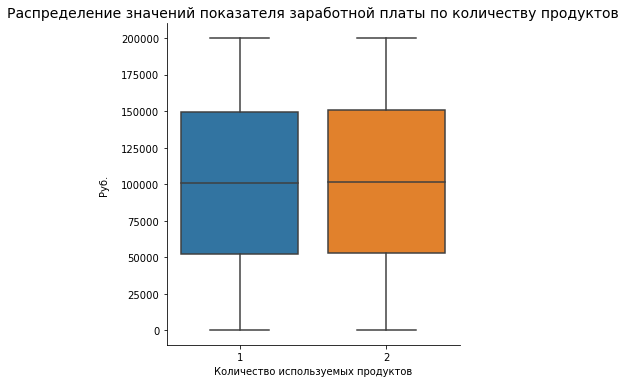

In [49]:
sns.catplot(x="Products", y="estimated_salary", kind="box", data=data)
plt.title('Распределение значений показателя заработной платы по количеству продуктов', fontsize=14)
plt.ylabel(feature_unit['estimated_salary'], labelpad=12)
plt.xlabel(feature_translate['Products'])
plt.show();

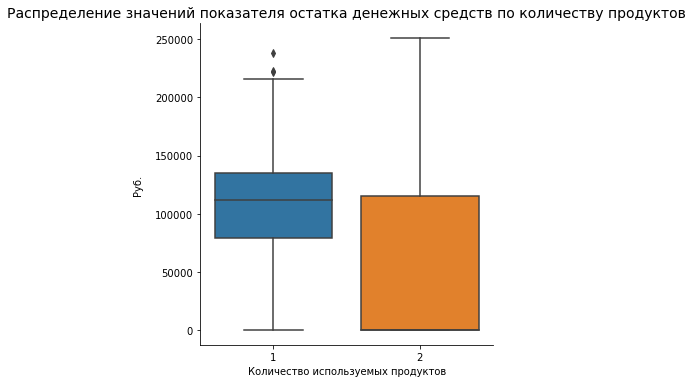

In [50]:
sns.catplot(x="Products", y="Balance", kind="box", data=data)
plt.title('Распределение значений показателя остатка денежных средств по количеству продуктов', fontsize=14)
plt.ylabel(feature_unit['Balance'], labelpad=12)
plt.xlabel(feature_translate['Products'])
plt.show();

Средняя заработная плата и распределение по квантилям у обеих групп совпадает. 

А вот для группы с 1 продуктом характерен более высокий средний остаток, т.к. клиенты из группы с 2 продуктами активнее используют кредитные счета и карты. Заметим, что встречаются и клиенты из 2 группы с высоким остатком. Максимальный остаток на счете составляет 250 000 руб, а зарплата - 200 000.

Теперь расмотрим отличаются ли сегменты по доходу и балансу территориально.

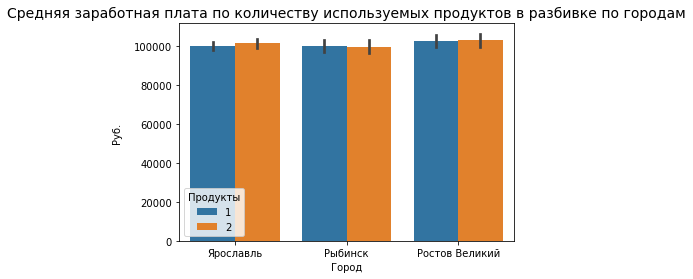

In [51]:
sns.barplot(x="City", y="estimated_salary", data=data, hue='Products') 
plt.title("Средняя заработная плата по количеству используемых продуктов в разбивке по городам", fontsize=14)
plt.ylabel(feature_unit['estimated_salary'], labelpad=12)
plt.xlabel(feature_translate['City'])
plt.legend(title="Продукты")
plt.show();

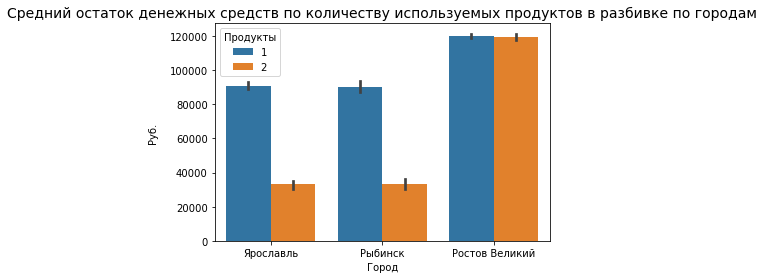

In [52]:
sns.barplot(x="City", y="Balance", data=data, hue='Products') 
plt.title("Средний остаток денежных средств по количеству используемых продуктов в разбивке по городам", fontsize=14)
plt.ylabel(feature_unit['estimated_salary'], labelpad=12)
plt.xlabel(feature_translate['City'])
plt.legend(title="Продукты")
plt.show();

Заработная плата в городах также равномерно распределена между группами. А вот баланс в Ростове выше, и примерно равен по группам. В Ярославле и Рыбинске баланс по группе с 1 продуктом значительно превышает баланс по группе с 2 продуктами.

*Размер заработной платы равномерно распределен между группами и по городам. Далее следует проверить гипотезу о равенстве средней заработной платы для наших групп.*

#### 3.3. Анализ сегментов по оттоку
<a id='step3_3'></a>

Перейдем к анализу оттока по группам используемых продуктов.

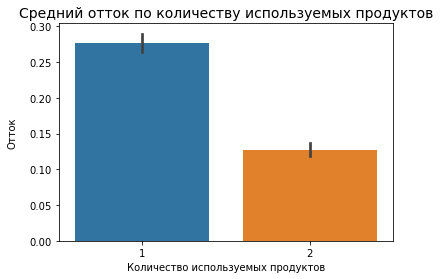

In [53]:
sns.barplot(y="Churn", x='Products', data=data) 
plt.title("Средний отток по количеству используемых продуктов", fontsize=14)
plt.ylabel(feature_translate['Churn'], labelpad=12)
plt.xlabel(feature_translate['Products'])
plt.show();

 В среднем отток в группе с 1 продуктом выше и составляет 27 % против 13% у группы с 2 продуктами.

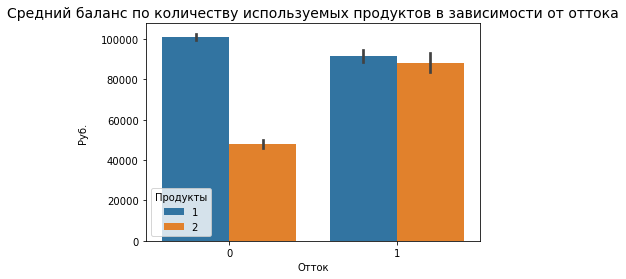

In [54]:
sns.barplot(x="Churn", y="Balance", data=data, hue='Products') 
plt.title("Средний баланс по количеству используемых продуктов в зависимости от оттока", fontsize=14)
plt.ylabel(feature_unit['estimated_salary'], labelpad=12)
plt.xlabel(feature_translate['Churn'])
plt.legend(title="Продукты")
plt.show();

В отток уходят клиенты с большим балансом из второй группы и с меньшим - из первой. Мы теряем платежеспособную категорию!

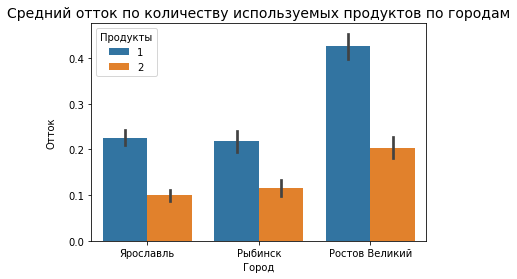

In [55]:
sns.barplot(x="City", y="Churn", data=data, hue='Products') 
plt.title("Средний отток по количеству используемых продуктов по городам", fontsize=14)
plt.ylabel(feature_translate['Churn'], labelpad=12)
plt.xlabel(feature_translate['City'])
plt.legend(title="Продукты")
plt.show();

Высокий уровень оттока в Ростове в группе с 1 продуктом (более 40%). 

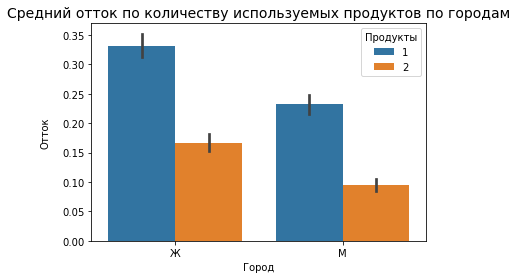

In [56]:
sns.barplot(x="Gender", y="Churn", data=data, hue='Products') 
plt.title("Средний отток по количеству используемых продуктов по городам", fontsize=14)
plt.ylabel(feature_translate['Churn'], labelpad=12)
plt.xlabel(feature_translate['City'])
plt.legend(title="Продукты")
plt.show()

Отток у мужчин ниже, чем у женщин.

**Вывод по шагу 3**

* Для анализа клиентов по количеству потребляемых продуктов мы разделили нашу выборку на 2 части: клиенты использующие 1 продукт, клиенты, использующие 2 и более продукта.  
* Клиенты 1 группы имеют более высокий средний остаток на счете, который в среднем в 2 раза выше его заработной платы.
* Киенты из группы с 2 продуктами активнее используют кредитные счета и карты, поэтому у них ниже средний остаток. При этом клиенты 2 группы реже уходят.
* В Ростове средний баланс по группам одинаков, а в Рыбинске и Ярославле баланс по 1 группе выше.
* В Ростове очень высокий показатель оттока в 1 группе, это клиенты с высоким доходом. Опасная тенденция. 

Проверим гипотезы о равенстве доходов и оттока

### Шаг 4. Проверка статистических гипотез

#### 4.1. Проверка гипотезы о равенстве доходов между сегментами.
<a id='step4_1'></a>

Проверим гипотезу:  
HO: Различие средней зарплаты в группах 1 и 2 статистически незначимо.  
H1: Различие средней зарплаты в группах 1 и 2 статистически значимо.

In [57]:
alpha = 0.05

In [58]:
one_prod_sal=data.loc[data['Products']==1, 'estimated_salary']

In [59]:
two_prod_sal=data.loc[data['Products']==2, 'estimated_salary']

Поскольку в разделе исследовательского анализа данных мы убедились, что распределение заработной платы далеко от нормального, а количество наблюдений достаточно (более 5000), для рассчета p_value используем критерий Манна-Уитни.

In [60]:
result = st.mannwhitneyu(one_prod_sal, two_prod_sal, True, 'two-sided')

In [61]:
print('p-значение: ', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  0.5702810506131595
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


*Следовательно группы не отличаются по среднему размеру заработной платы*

#### 4.2. Проверка гипотезы о равенстве оттока клиентов между сегментами.
<a id='step4_1'></a>

Проверим гипотезу:  
HO: Различие оттока в группах 1 и 2 статистически незначимо.  
H1: Различие оттока в группах 1 и 2 статистически значимо.

In [62]:
one_prod_churn=data.loc[data['Products']==1, 'Churn']

In [63]:
two_prod_churn=data.loc[data['Products']==2, 'Churn']

Т.к. мы имеем дело с категориальной переменной, так же применим критерий Манна-Уитни. Количество наблюдений достаточно.

In [64]:
result = st.mannwhitneyu(one_prod_churn, two_prod_churn, False, 'two-sided')

In [65]:
print('p-значение: ', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  9.02958547019877e-75
Отвергаем нулевую гипотезу: разница статистически значима


*Можно сделать вывод о том, что разница в доле оттока между группами различна.*

**Вывод по шагу 4:**
* Группы не отличаются по средней зарплате
* Отток в первой группе существенно выше, чем во второй.

### Шаг 5. Формирование общих выводов и рекомендаций по исследованию:

#### 5.1. Формирование общих выводов.
<a id='step5_1'></a>

В исходных данных содержаться данные об 10 000 клиентов банка "Метанпром": пол, возраст, город проживания, баланс, зарплата, количество объектов в собственности, количество используемых продуктов, наличие кредитной карты, указание на лояльность клиента, а также информация о том ушел клиент или остался.

**Из проведенного исследовательского анализа мы выяснили следующее:**
* Почти половина клиентов проживает в городе Ярославль. Остальные поровну поделены между Рыбинском и Ростовом.
* Средний возраст клиента 39 лет. Мужчин больше, чем женщин почти на 1000 человек.
* Половина клиентов - пользуется только 1 продуктом, 4500 клиентов - двумя, и только 500 человек - используют 3 и более продукта.
*  Средняя оценочная зарплата состовляет около 100000 руб.
* 70% клиентов имеют кредитную карту. 51% - это лояльные клиенты.
* В целом из 10000 клиентов в отток попало 20,4%.
* Не наблюдается сильных корреляций между признаками. Определенная положительная взаимосвязь прослеживается между признаками "Баланс" и местонахождением клиента, между возрастом и оттоком, а также отрицательная - между оттоком и количеством продуктов 

Т.к. целью нашего исследования является выделение наиболее привлекательных групп и корректировка стратегии взаимодействия с ними, мы убрали из исследования данные 284 человек: старше 72 лет, клиентов с показателем кредитного скорринга менее 432, клиентов с неверной оценкой заработной платы (превышение баланса над зарплатой в 35 раз)

**В ходе анализа клиентов по сегментам мы пришли к следующим выводам:**

* Для анализа клиентов по количеству потребляемых продуктов мы разделили нашу выборку на 2 части: клиенты использующие 1 продукт, клиенты, использующие 2 и более продукта.  
* Клиенты 1 группы имеют более высокий средний остаток на счете, который в среднем в 2 раза выше его заработной платы.
* Киенты из группы с 2 продуктами активнее используют кредитные счета и карты, поэтому у них ниже средний остаток. При этом клиенты 2 группы реже уходят.
* В Ростове средний баланс по группам одинаков, а в Рыбинске и Ярославле баланс по 1 группе выше.
* В Ростове очень высокий показатель оттока в 1 группе, это клиенты с высоким доходом. Опасная тенденция. 

#### 5.2. Формирование рекомендаций по результатам исследования.
<a id='step5_2'></a>

* Для клиентов первой группы можно больше предлагать дополнительных продуктов, чтобы снизить вероятность оттока.
* У клиентов второй группы больше сосредоточиться на клиентах с большим остатком денежных средств (они чаще уходят): предложить спецпредложения по депозитным счетам или скидку по кредитным ставкам.
* Возможно следует разграничить стратегии взаимодействия отдельно для Ростова и отдельно для Ярославля с Рыбинском, поскольку жители Ростова имеют больший средний остаток и больше подвержены оттоку.
* Попробовать использовать методы ML, если потребуется более детальная сегментация клиентов.
* Следует попытаться улучшить оценку средней заработной платы, поскольку этот показатель во многом не позволяет сделать реальных выводов о доходе клиентов. Запрашивать разрешения у клиентов на выписку из ПФР, делать более выгодные предложения по ставкам при подтверждении доходов.

#### 5.3. Дополнительные материалы к исследованию.
<a id='step5_3'></a>

1. Презентация (https://yadi.sk/i/loBLSbZX4vmJBQ)
2. Дашборд (https://public.tableau.com/profile/elmira8383#!/vizhome/Graduate_project/Dashboard2)